In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mplcursors as mplc

In [2]:
df = pd.read_csv('ags-shots-2025-03-08.csv')

In [3]:
df.head()

,Date,Club Type,Club Description,Altitude,Club Speed,Ball Speed,Carry Distance,Total Distance,Roll Distance,Smash,...,Spin Rate,Spin Axis,Spin Reading,Low Point,Club Path,Face Path,Face Target,Swing Plane Tilt,Swing Plane Rotation,Shot Classification
0,NaN,NaN,NaN,[ft],[mph],[mph],[yd],[yd],[yd],NaN,...,[rpm],[deg],NaN,[in],[deg],[deg],[deg],[deg],[deg],NaN
1,2025-03-08 10:54:25,7 Iron,NaN,5600.00,77.85,93.95,140.69,157.56,16.86,1.21,...,4681,-11.50,Actual,NaN,NaN,NaN,NaN,NaN,NaN,Pull Draw
2,2025-03-08 10:54:42,7 Iron,NaN,5600.00,78.29,101.56,155.21,170.88,15.67,1.30,...,5408,-6.80,Actual,NaN,NaN,NaN,NaN,NaN,NaN,Draw
3,2025-03-08 10:55:21,7 Iron,NaN,5600.00,77.17,98.43,147.46,162.62,15.16,1.28,...,5842,2.60,Actual,NaN,NaN,NaN,NaN,NaN,NaN,Straight
4,2025-03-08 10:55:43,7 Iron,NaN,5600.00,78.29,99.77,150.34,166.09,15.76,1.27,...,5783,-4.50,Actual,NaN,NaN,NaN,NaN,NaN,NaN,Pull


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    120 non-null    object 
 1   Club Type               120 non-null    object 
 2   Club Description        0 non-null      float64
 3   Altitude                121 non-null    object 
 4   Club Speed              121 non-null    object 
 5   Ball Speed              121 non-null    object 
 6   Carry Distance          121 non-null    object 
 7   Total Distance          121 non-null    object 
 8   Roll Distance           121 non-null    object 
 9   Smash                   120 non-null    float64
 10  Vertical Launch         121 non-null    object 
 11  Peak Height             121 non-null    object 
 12  Descent Angle           121 non-null    object 
 13  Horizontal Launch       121 non-null    object 
 14  Carry Lateral Distance  121 non-null    ob

In [5]:
df = df.drop(['Club Description', 'Attack Angle','Dynamic Loft', 'Attack Angle', 'Dynamic Loft', 
         'Spin Loft', 'Low Point' , 'Club Path', 'Face Path', 'Face Target' , 
         'Swing Plane Tilt', 'Swing Plane Rotation'], axis=1)
df.dropna(inplace=True)


In [6]:
df['Club Type'].unique()
df['Club Color'] = 0.0

def assign_color(idx, row):
    if row['Club Type'] == '9 Iron':
        df.loc[idx, 'Club Color']  = 2.0
    elif row['Club Type'] == '8 Iron':
        df.loc[idx, 'Club Color'] = 3.0
    elif row['Club Type'] == '7 Iron':
        df.loc[idx, 'Club Color'] = 4.0
    elif row['Club Type'] == '6 Iron':
        df.loc[idx, 'Club Color'] = 5.0
    elif row['Club Type'] == '5 Iron':
        df.loc[idx, 'Club Color'] = 6.0
    elif row['Club Type'] == '4 Iron':
        df.loc[idx, 'Club Color'] = 7.0
    elif row['Club Type'] == '3 Iron':
        df.loc[idx, 'Club Color'] = 8.0
    elif row['Club Type'] == 'Pitching Wedge':
        df.loc[idx, 'Club Color'] = 1.0

for index, row in df.iterrows():
    assign_color(index, row)

In [7]:
df.head()

df['Ball Speed'] = pd.to_numeric(df['Ball Speed'])
df['Carry Distance'] = pd.to_numeric(df['Carry Distance'])
df['Carry Lateral Distance'] = pd.to_numeric(df['Carry Lateral Distance'])


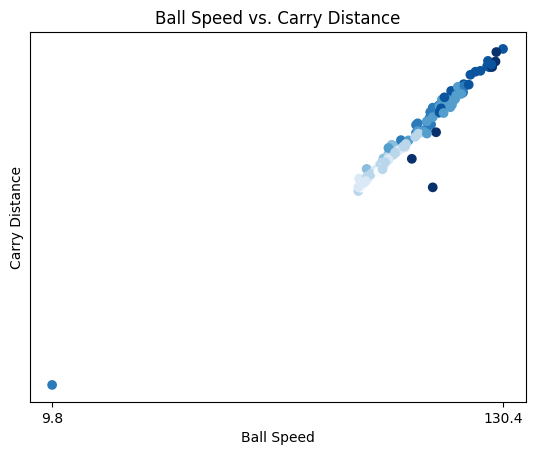

In [8]:
xpoints = df['Ball Speed']
ypoints = df['Carry Distance']

plt.scatter(xpoints, ypoints, c=df['Club Color'], cmap='Blues', label='Club Type')
#plt.legend(df['Club Type'], df['Club Color'])

max_speed = df['Ball Speed'].max()
min_speed = df['Ball Speed'].min()
max_dist = df['Carry Distance'].max()

plt.xticks([max_speed, min_speed])
plt.yticks([])
plt.xlabel('Ball Speed')
plt.ylabel('Carry Distance')
plt.title('Ball Speed vs. Carry Distance')
plt.show()

Removing the one horrilble shank that had a ball speed of 9.8 mph

In [9]:
min_index = df['Carry Distance'].idxmin()
df = df.drop(min_index)


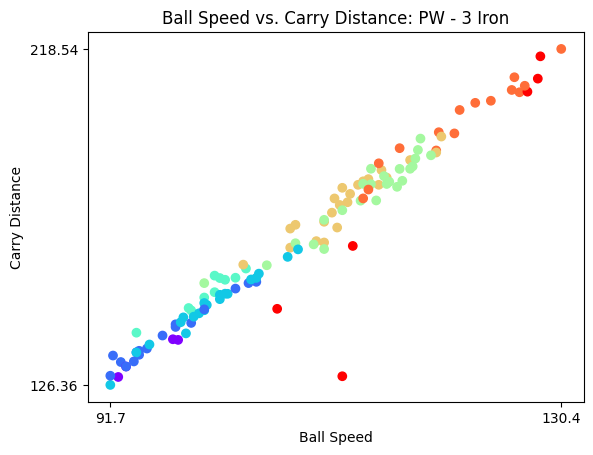

In [10]:
max_speed = df['Ball Speed'].max()
min_speed = df['Ball Speed'].min()
max_dist = df['Carry Distance'].max()
min_dist = df['Carry Distance'].min()

xpoints = df['Ball Speed']
ypoints = df['Carry Distance']

plt.scatter(xpoints, ypoints, c=df['Club Color'], cmap='rainbow', label='Club Type')

plt.xticks([max_speed, min_speed])
plt.yticks([min_dist, max_dist])
plt.xlabel('Ball Speed')
plt.ylabel('Carry Distance')
plt.title('Ball Speed vs. Carry Distance: PW - 3 Iron')
plt.show()

Looks much better, now I will remove the 3 red outliers. My 3 iron broke during the data collection and these were the 2 shots prior to the club breaking and the 1 shot that the club head flew off of the shaft.

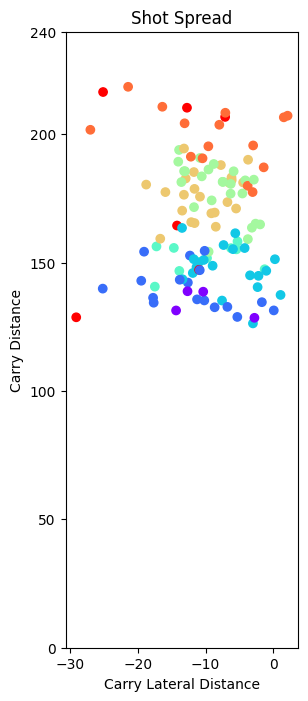

In [11]:
ypoints = df['Carry Distance']
xpoints = df['Carry Lateral Distance']


plt.figure(figsize=(3, 8))
plt.scatter(xpoints, ypoints, c=df['Club Color'], cmap='rainbow', label='Club Type')

#plt.xticks([max_speed, min_speed])
plt.yticks([0, 50, 100, 150,200,240])
plt.ylabel('Carry Distance')
plt.xlabel('Carry Lateral Distance')
plt.title('Shot Spread')
mplc.cursor(hover=True)
plt.show()